In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)

2.13.0


In [3]:
# directories
TRAIN_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/train"
VALIDATION_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/validation"
TEST_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/test"

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
training_images = image_dataset_from_directory(
    TRAIN_DIR,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 3115 files belonging to 36 classes.


In [6]:
validation_images = image_dataset_from_directory(
    VALIDATION_DIR,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 351 files belonging to 36 classes.


In [7]:
testing_images = image_dataset_from_directory(
    TEST_DIR,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 359 files belonging to 36 classes.


In [8]:
class_names = training_images.class_names
class_names

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

training_image_aug = training_images.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
training_images = tf.data.Dataset.zip((training_images, training_image_aug)).flat_map(
    lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y))
)

In [11]:
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

training_images = training_images.map(normalize)
validation_images =  validation_images.map(normalize)
testing_images =  testing_images.map(normalize)

In [12]:
training_images = training_images.prefetch(tf.data.experimental.AUTOTUNE)
validation_images = validation_images.prefetch(tf.data.experimental.AUTOTUNE)
testing_images = testing_images.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
filter = 64
activation = 'relu'

model = tf.keras.models.Sequential([
    # input layer
    tf.keras.Input(IMAGE_SIZE + (3,)),

    # CNN layers
    tf.keras.layers.Conv2D(filter, kernel_size=(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filter*2, kernel_size=(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filter*4, kernel_size=(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filter*8, kernel_size=(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filter*16, kernel_size=(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    # max pooling layer
    tf.keras.layers.GlobalMaxPooling2D(),
    
    # output layer
    tf.keras.layers.Dense(36)
])
    
    
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                      

In [15]:
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1)

In [16]:
history = model.fit(
    training_images,
    validation_data=validation_images,
    epochs=50,
    callbacks=[lr_callback]
)

Epoch 1/50
196/196 [==============================] - 95s 369ms/step - loss: 2.3924 - accuracy: 0.3592 - val_loss: 4.4042 - val_accuracy: 0.0484 - lr: 1.0000e-04
Epoch 2/50
196/196 [==============================] - 74s 333ms/step - loss: 1.5596 - accuracy: 0.5401 - val_loss: 3.7735 - val_accuracy: 0.1168 - lr: 1.0000e-04
Epoch 3/50
196/196 [==============================] - 75s 333ms/step - loss: 1.2561 - accuracy: 0.6289 - val_loss: 0.8673 - val_accuracy: 0.8091 - lr: 1.0000e-04
Epoch 4/50
196/196 [==============================] - 74s 332ms/step - loss: 1.0499 - accuracy: 0.6909 - val_loss: 0.4262 - val_accuracy: 0.8946 - lr: 1.0000e-04
Epoch 5/50
196/196 [==============================] - 74s 329ms/step - loss: 0.9132 - accuracy: 0.7348 - val_loss: 0.2564 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 6/50
196/196 [==============================] - 74s 331ms/step - loss: 0.8211 - accuracy: 0.7631 - val_loss: 0.2926 - val_accuracy: 0.9288 - lr: 1.0000e-04
Epoch 7/50
196/196 [========

In [17]:
val_loss,val_accuracy=model.evaluate(testing_images)

12/12 [==============================] - 8s 177ms/step - loss: 0.1733 - accuracy: 0.9610


In [18]:
model.save('capstone_v2.h5')
model.save('capstone_v2.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


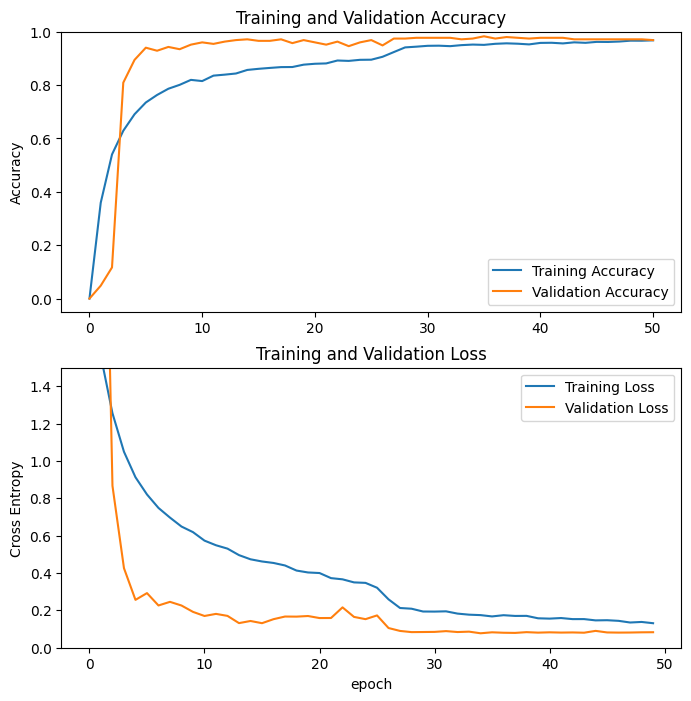

In [19]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [21]:
download_file('/kaggle/working', 'gelu')

/kaggle/working/gelu.zip